In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [3]:
# function to create a 3D plot of the firing rates of cells

def create3Dplot(rows,cols,Z):
    # Generate the grid
    x = np.arange(0, rows, 1)  # Equivalent to -5:0.1:5 in MATLAB
    y = np.arange(0, cols, 1)
    X, Y = np.meshgrid(x, y)

    # Create the 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

    # Add labels and title

    ax.set_title('3D Surface Plot')

    # Add a colour bar for the surface
    #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Show the plot
    plt.ion()
    plt.show()
    plt.pause(0.001)
    input("Press Enter to continue...")  # Wait for the user to press Enter
    plt.close(fig)

In [4]:
# STEP 1: Assign memory for the weights matrix and create an environment with a cell representing each location
# initialisation for place cells
pc_rows = 20
pc_cols = 20
pc_nCells = pc_rows *pc_cols
pc_weightsMat = np.zeros(((pc_rows, pc_cols, pc_nCells)))
nIterations = 10
NetThreshold = 0.5


# Create an index sheet for the PC output
# PC_idx is a 10x10 matrix where each element represents a unique index from 0 to 99
PC_idx = np.arange(pc_rows * pc_cols).reshape(pc_rows, pc_cols)

In [ ]:
# STEP 2: Initialize sensory cells' firing fields with Gaussian distributions
sc_nCells = 10  # Number of sensory cells
env_rows = 20  # Environment grid size (20x20 bins)
env_cols = 20
env = np.zeros((env_rows, env_cols))
# Determine how big each Gaussian firing field covers. 
# Approx. covers 1/3 of the environment.
sc_firing_fields = np.zeros((sc_nCells, env_rows, env_cols)) 
# Create a 3D array to store firing fields for each sensory cell across the environment.
# Dimensions are: (number of sensory cells, rows of environment, columns of environment).


In [ ]:
# STEP 3: evenly space sensory cells
# Calculate the number of rows and columns for even spacing
n_rows = int(np.sqrt(sc_nCells))
n_cols = int(np.ceil(sc_nCells / n_rows))

# Evenly space the sensory cells within the environment grid
row_positions = np.linspace(1, env_rows - 1, n_rows, dtype=int)
col_positions = np.linspace(1, env_cols - 1, n_cols, dtype=int)

# Assign centers based on evenly spaced positions
centers = [(r, c) for r in row_positions for c in col_positions][:sc_nCells]

print(centers)

[(1, 1), (1, 7), (1, 13), (1, 19), (10, 1), (10, 7), (10, 13), (10, 19), (19, 1), (19, 7)]


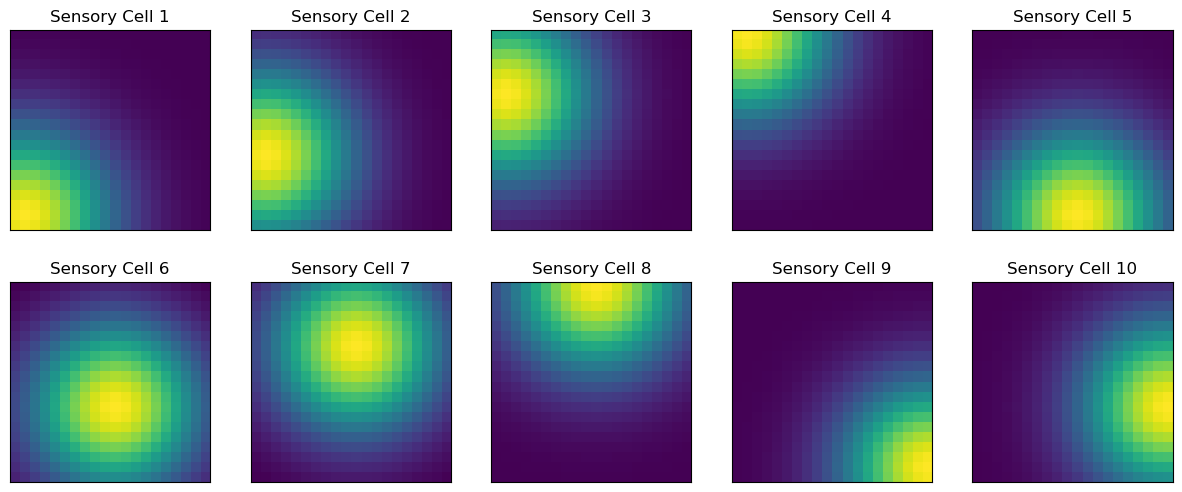

In [ ]:
# STEP 4: Create firing field of the sensory cells

# Define the Gaussian function for firing fields
def gaussian(X, Y, cx, cy, sigma=6):
    return np.exp(-((X - cx) ** 2 + (Y - cy) ** 2) / (2 * sigma ** 2))

# Create grid (X, Y) for the environment
X, Y = np.meshgrid(np.arange(env_rows), np.arange(env_cols))

# Compute Gaussian firing fields for each sensory cell center
for i, (cx, cy) in enumerate(centers):
    sc_firing_fields[i] = gaussian(X, Y, cx, cy)

# Plot the firing fields
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(sc_firing_fields[i], origin='lower', cmap='viridis')
    ax.set_title(f'Sensory Cell {i+1}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
# STEP 5: Create a weights matrix between the sensory cells and each of the place cells (attractor cells)
# Initialize weights matrix
sc2pc_weightsMat = np.zeros((sc_nCells, pc_nCells))

# Iterate over each place cell
for pc_idx in range(pc_nCells):
    # Get the row and column of the current place cell in the 20x20 environment
    row, col = divmod(pc_idx, env_cols)

    # Extract firing rates from all sensory cells at this location
    firing_rates = sc_firing_fields[:, row, col]

    # Normalize the firing rates
    normalized_rates = firing_rates / np.max(firing_rates) if np.max(firing_rates) > 0 else firing_rates

    # Assign firing rates to the weights matrix
    sc2pc_weightsMat[:, pc_idx] = normalized_rates

In [ ]:
# STEP 6: Initialise the weights in the weights matrix of place cells
    # The cell has a weight of 1 with itself and a weight of 0.5 with it's immediate neighbours
    
for cell in range(pc_nCells): # cycle through each cell
    # range(nCells) generates numbers from 0 to nCells - 1 (0 to 99 for a 10x10 grid)

    r, c = np.where(PC_idx == cell) # find the position of that cell in the PC sheet
    # nfinds where in the 2D array PC_idx this number exists and returns (row, col)
    
    pc_weightsMat[r,c,cell] = 1 # Set weight with itself to 1
    
    if r>0:   # If the row is not the top...
        pc_weightsMat[r-1,c,cell] = 0.5
    if r<pc_rows-1: # If row is not at the bottom... (Have to -1 because of python zero idx)
        pc_weightsMat[r+1,c,cell] = 0.5
    if c>0:
        pc_weightsMat[r,c-1,cell] = 0.5
    if c<pc_cols-1: # Have to -1 because of zero idx
        pc_weightsMat[r,c+1,cell] = 0.5
        

In [ ]:
# Step 7: Set initial firing rate in the enviornment
NetAct = np.random.uniform(low=0, high=1, size=(pc_rows, pc_cols))  # Add noise
# the firing rate (or activation) of the current cell in the grid, at the position
# NetAct is a matrix of the same size as the grid, with each element representing the firing rate of a corresponding cell in the grid.
# This firing rate is essentially how much influence that particular cell has in the network.

# Alternativly set initial activation to a specific value
#NetAct= (np.ones((rows, cols)))/2; #Set inital activity to 0.5


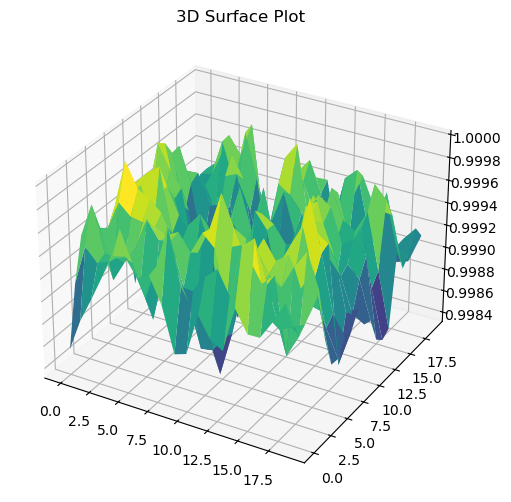

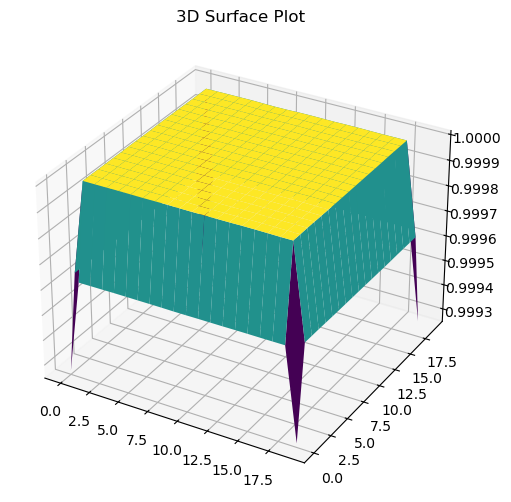

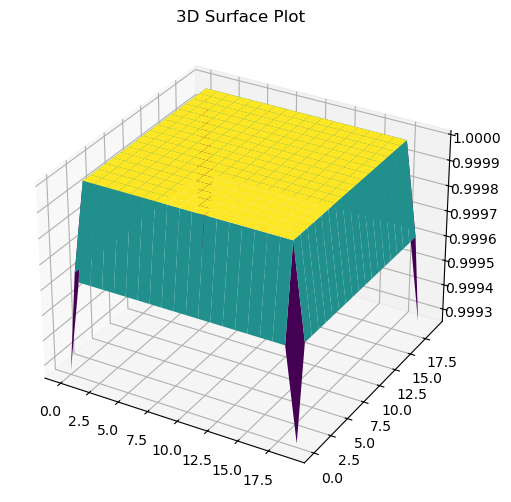

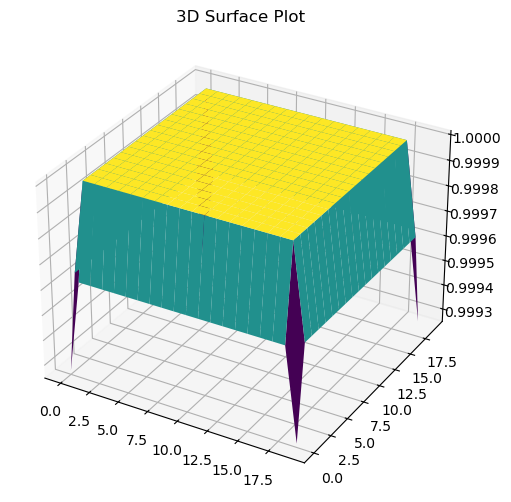

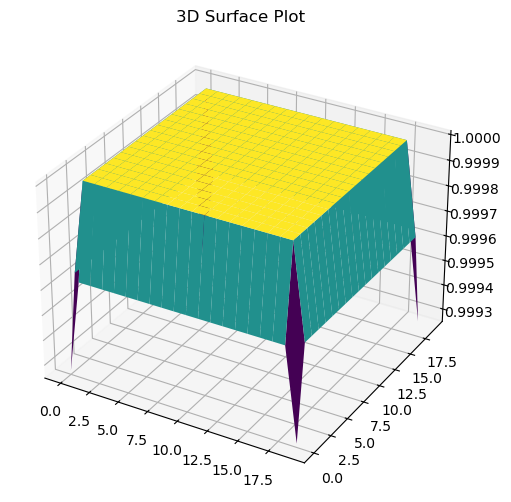

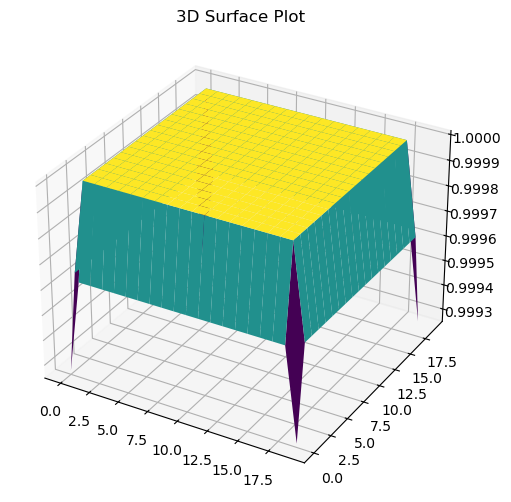

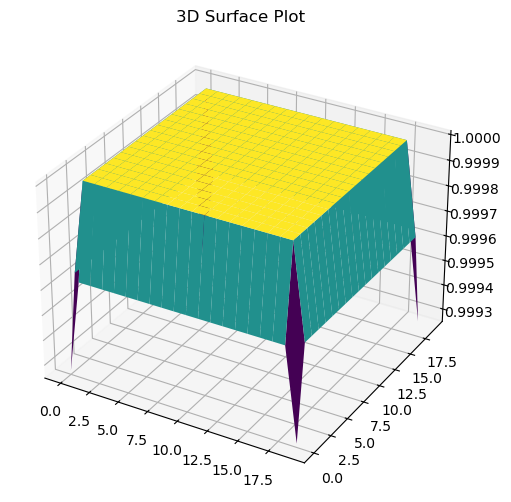

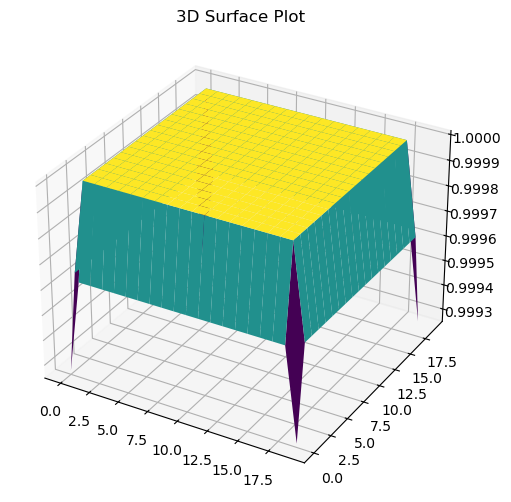

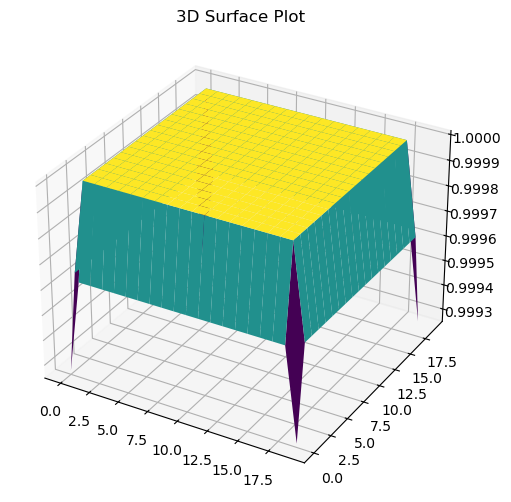

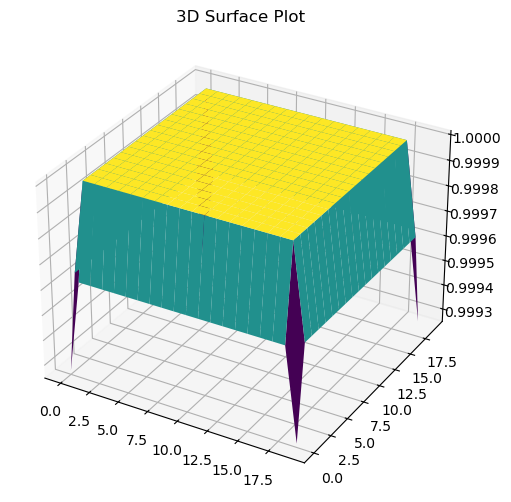

In [ ]:
# Step 8: Calculate the firing of each cell

for _ in range(nIterations):
    # the _ means: This loop is only running nIterations times, and I don’t need to track the loop variable.
    NetInput = np.zeros((pc_rows,pc_cols)) # create a temporary store of cell activity so they don't interact
    # draft version of NetAct where we compute all the new values first.
	# Once all updates are finished, we copy NetInput → NetAct.
    # Each iteration, NetInput starts fresh as a zero matrix, ensuring no leftover values from the previous step interfere
    for k in range(pc_nCells):
        row,col = np.where(PC_idx == k) # find row and column index of cell
        # k loops over all cell indices (0 to nCells - 1)
        # finds where each k is located in the 2D grid

        # Contribution from place cell network (W)
        place_cell_input = pc_weightsMat[:, :, k] * NetAct[row, col]
        # Contribution from sensory input (F_SW) - sum of sensory weights for this place cell
        sensory_influence = np.sum(sc2pc_weightsMat[:, k])
        
        # Update total input: F_A(t+1) = F_A(t) + W + F_SW  = update rule
        NetInput = NetInput + place_cell_input + sensory_influence
        # filling in each next cell on the temporary sheet
        
        # element-wise multiplication between the weight matrix slice weightsMat[:,:,k] and the activation of the current cell NetAct[row,col]
        # NetInput+ the result from the multiplication is added to NetInput. This accumulates the effects of all the cells,
        # on the current cell, effectively calculating the total input that each cell in the grid receives.
        # expresses a weighted sum of the activations of neighboring cells, forming the total input (NetInput) for the current iteration.


        # PC_idx[row, col] == k ensures each cell is linked to one specific (row, col) position.
        # weightsMat[:, :, k] is designed so that the k-th slice always corresponds to the same k in PC_idx.
        # The loop over k (for k in range(nCells)) ensures we update each place cell exactly once.
        
   
    NetInput = NetInput / np.max(NetInput)  # Normalise to values between 0 & 1
    # fire rate relative between cells as they dont just keep firing 
    
                   # Clear the figure for the next iteration


    NetInput = NetInput * (NetInput >= NetThreshold)  # Threshold
    # For each element in the NetInput matrix:
    # If the value is greater than or equal to NetThreshold, the corresponding position will be 1
    # If the value is less than NetThreshold, the corresponding position in the boolean mask will be 0
    # element-wise multiplication between the NetInput matrix and the boolean mask

    # When NetInput >= NetThreshold is True (i.e., 1), the corresponding value in NetInput remains unchanged.
    # When NetInput >= NetThreshold is False (i.e., 0), the corresponding value in NetInput is set to 0.
    # Cells with values below the threshold are set to zero, effectively “turning off” those cells’ activity.
    
    NetAct = NetInput.copy()  # Set Input to each cell as the new firing rate
    
    create3Dplot(pc_rows,pc_cols,NetAct) # plot - you need to press Enter to progress on to next iteration
       
       